# Predict Titanic Survival Rates

In [2]:

import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

#import sklearn
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
)


from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, Imputer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder
)

from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, SelectPercentile, 
    SelectFromModel, f_regression, RFECV
)

from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.model_selection import GridSearchCV

from sklearn.base import TransformerMixin, BaseEstimator

from utils import separation_plot
from sklearn.pipeline import Pipeline, FeatureUnion

In [3]:
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    '''ordinal encoder
    initialize by passing in the possible values IN ORDER
    CustomEncoder(['S', 'M', 'L'])
    CustomEncoder(['Abysmal', 'Po', 'Go','Ex'])
    '''

    def __init__(self, categories):
        self.categories = categories
        return None

    def fit(self, X, **fit_params):
        assert np.alltrue([x in self.categories for x in np.unique(X)]), 'Item Mismatch'
        self.categories_ = {v: k+1 for k, v in enumerate(self.categories)}
        return self

    def transform(self, X):
        s = np.array([self.categories_[x] for x in np.array(X)])
        return s

In [4]:
titanic_df = pd.read_csv('data/train.csv')
test_df= pd.read_csv('data/test.csv')

titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
def make_pair_plot(df_corr):
    # Set the default matplotlib figure size to 7x7:
    fix, ax = plt.subplots(figsize=(5,5))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(df_corr, mask=mask, ax=ax, annot=True, cmap="BrBG")

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

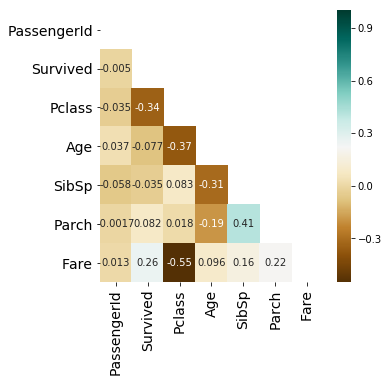

In [8]:
make_pair_plot(titanic_df.corr())

In [9]:
X_train, X_test, y_train, y_test = train_test_split(titanic_df.iloc[:,:], titanic_df['Survived'], random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
298,299,1,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,C106,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.00,0,0,SOTON/OQ 392076,7.0500,NaN,S
247,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.00,0,2,250649,14.5000,NaN,S
478,479,0,3,"Karlsson, Mr. Nils August",male,22.00,0,0,350060,7.5208,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S


In [12]:
# data does not need to be scaled for decision tree
mapper = DataFrameMapper([
    
    #pclass Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
    ('Pclass',[CategoricalImputer(strategy='mode'), LabelBinarizer()]),
  #   ('Name',None), #[CategoricalImputer(replacement="unknown")]),
    # skip name for now
    #Sex    male/female
    (['Sex'],  [CategoricalImputer(strategy='mode'), OrdinalEncoder()]),
    (['Age'],[SimpleImputer(strategy='median')]),
    (['SibSp'],[SimpleImputer(strategy='constant', fill_value=0)]),
    (['Parch'],[SimpleImputer(strategy='constant', fill_value=0)]),
   
    # skipping ticket, fare and cabin for now
    ('Embarked',[CategoricalImputer(strategy='mode'), LabelBinarizer()])

], df_out=True)


In [18]:
'''
This class performs feature engineering on the retrieved posts.  It is designed to be used in a pipeline
It takes no special input parameters beyond X (the dataframe to be transformed) and returns a modified version of X
with some additional, calculated columns.
Columns Created:
* family_count: sum of parent/child and siblings

TODO:
* extract title from name
* calculate is child / do better job of age filling

'''
class TitanicTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        X['family_count'] = X['Parch'] + X['SibSp']
        X = X.drop(columns=['Parch','SibSp'], axis=1)
    
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [19]:

pipe1a = Pipeline([
    ('map', mapper),
    ('feature_gen', TitanicTransformer())
])


In [20]:
pipe1a = pipe1a.fit(X_train)
X_train = pipe1a.transform(X_train)


In [21]:
X_train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex,Age,Embarked_C,Embarked_Q,Embarked_S,family_count
298,1,0,0,1.0,28.00,0,0,1,0
884,0,0,1,1.0,25.00,0,0,1,0
247,0,1,0,0.0,24.00,0,0,1,2
478,0,0,1,1.0,22.00,0,0,1,0
305,1,0,0,1.0,0.92,0,0,1,3


In [22]:
X_test =  pipe1a.transform(X_test)
X_test.head()

,Pclass_1,Pclass_2,Pclass_3,Sex,Age,Embarked_C,Embarked_Q,Embarked_S,family_count
709,0,0,1,1.0,28.0,1,0,0,2
439,0,1,0,1.0,31.0,0,0,1,0
840,0,0,1,1.0,20.0,0,0,1,0
720,0,1,0,0.0,6.0,0,0,1,1
39,0,0,1,0.0,14.0,1,0,0,1


## Decision Tree

### GridSearch for Best Decision Tree parameters

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
%%time

cart_params = {
    'criterion':['gini','entropy'],
    'max_depth':[2, 3,4,5,6,7,10],
    'max_leaf_nodes':[20,23, 25,27,30,35,40]
}


cart_gridsearch = GridSearchCV(DecisionTreeClassifier(), cart_params, cv=5, verbose=1, n_jobs=2)

cart_gridsearch = cart_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Wall time: 5.52 s


[Parallel(n_jobs=2)]: Done 490 out of 490 | elapsed:    5.4s finished


In [27]:
cart_gridsearch.best_params_

{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 20}

In [28]:
classifier = DecisionTreeClassifier(criterion='entropy',max_depth=6, max_leaf_nodes=40)

classifier.fit(X_train, y_train)

Y_pred = classifier.predict(X_test)


In [29]:
classifier.score(X_test, y_test)
#.72 with max depth none
#.7713 with max depth 5

0.7892376681614349

In [30]:
confusion_matrix(y_test, Y_pred)

array([[119,  15],
       [ 32,  57]], dtype=int64)

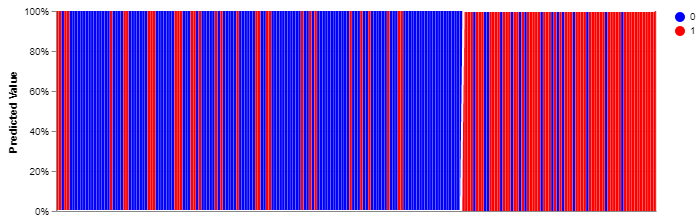

In [31]:
separation_plot(y_test, Y_pred)

In [32]:
feature_importances = classifier.feature_importances_
feature_importances

array([0.0457594 , 0.        , 0.15415963, 0.40887897, 0.25663515,
       0.00558041, 0.        , 0.00718063, 0.12180582])

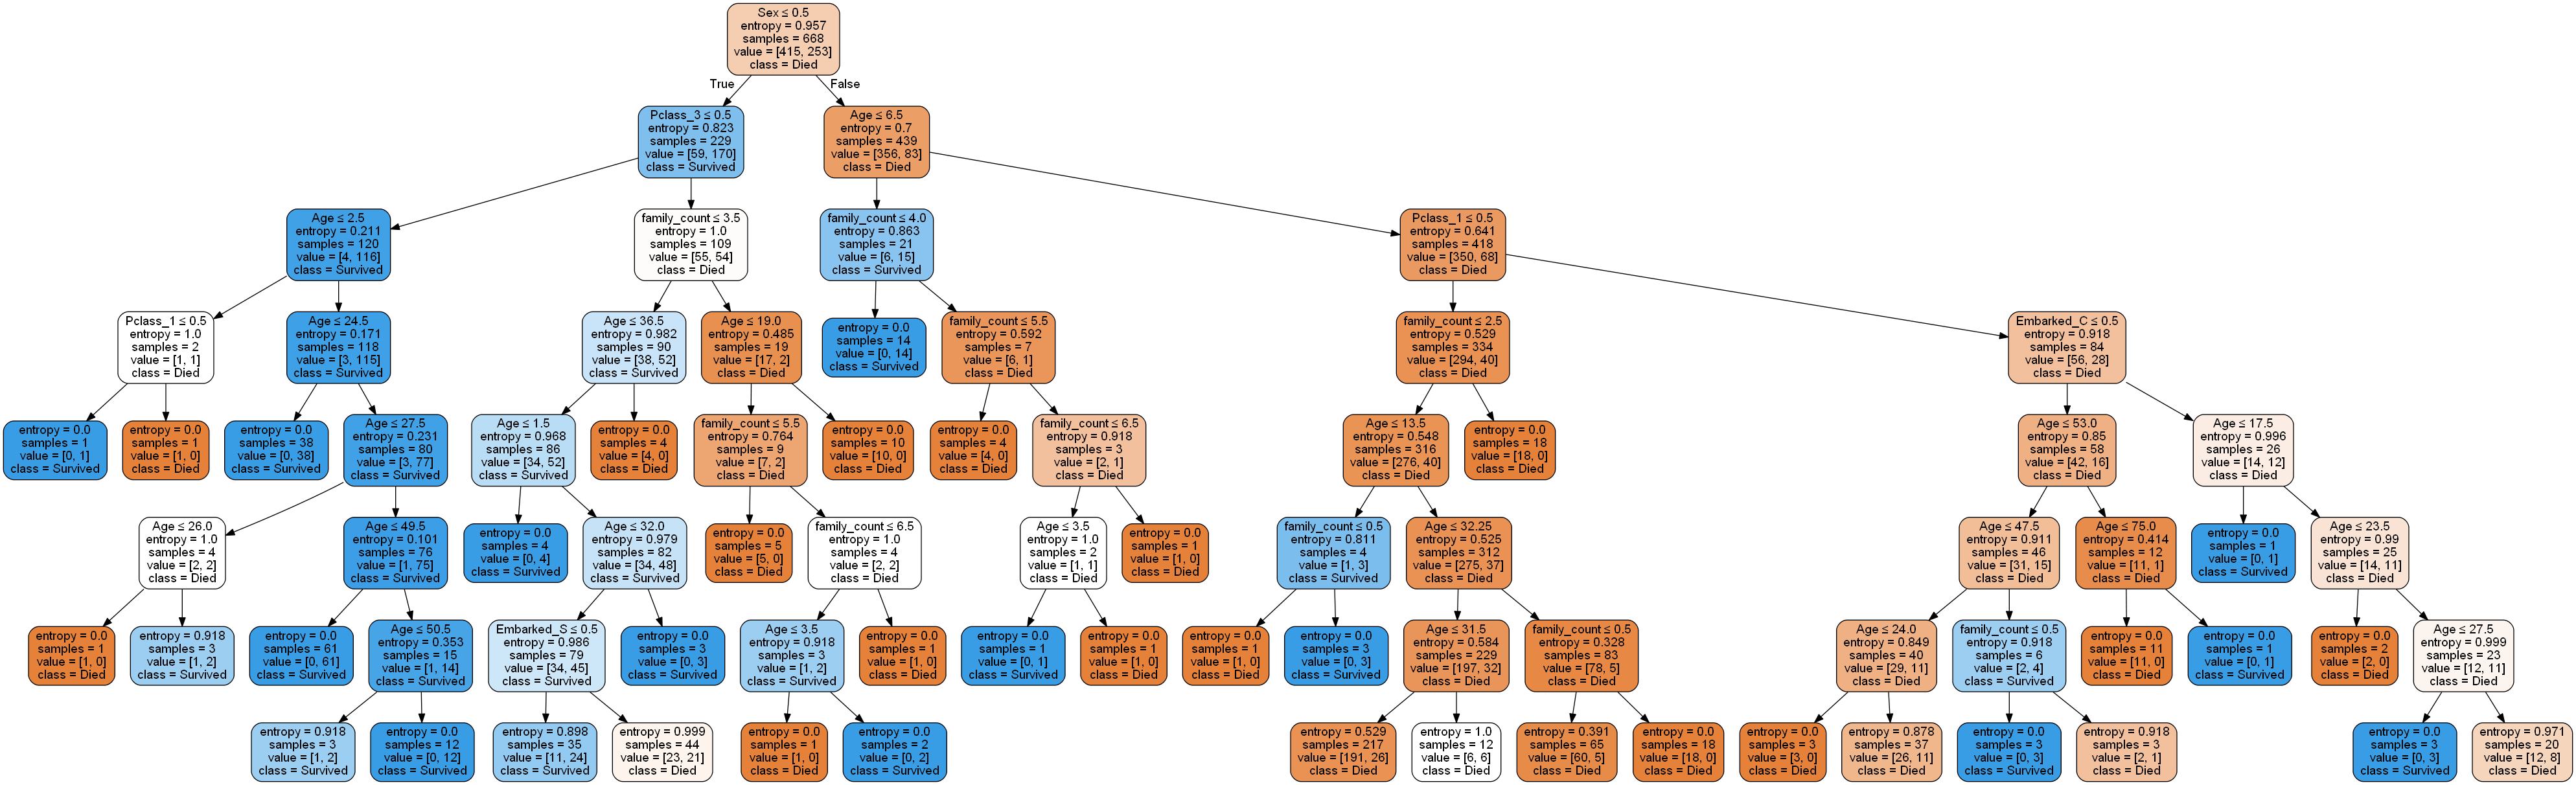

In [33]:
# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                 feature_names=X_train.columns,
        class_names=["Died", "Survived"])  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

# compare with Logistic Regression

In [34]:
lr=LogisticRegression()
lr = lr.fit(X_train, y_train)
lr.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8071748878923767

In [35]:

Y_pred2 = lr.predict(X_test)
confusion_matrix(y_test, Y_pred2)

array([[116,  18],
       [ 25,  64]], dtype=int64)

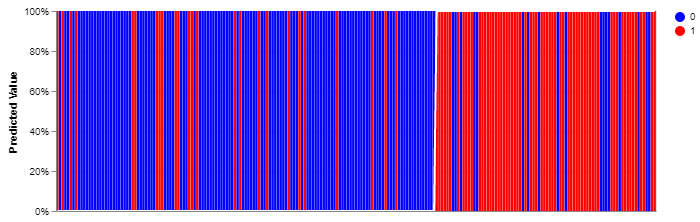

In [36]:
separation_plot(y_test, Y_pred2)

#### Generate predictions for the test data

In [41]:
PassengerId_test =  test_df['PassengerId']
X_final_test = pipe1a.transform(test_df)

In [42]:
Y_final_pred = classifier.predict(X_final_test)

In [43]:
Y_final_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [45]:
titanic_test = pd.DataFrame({
    'PassengerID': PassengerId_test,
    'Survived': pd.Series(Y_final_pred)
})
# titanic_test['PassengerID'] = PassengerId_test
# titanic_test['Survived'] = pd.Series(Y_final_pred)
titanic_test.to_csv("decision_trees_simple.csv", index=False)